In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.autonotebook import tqdm
from IPython import display
from scipy.io import wavfile
import processing as pr

In [2]:
#data
model_name = "SWaT"

In [3]:
train_set, test_set, label_set = pr.SWaT()

In [4]:
if model_name == "SMD" or model_name == "SWaT":
    print("yes")
    train_set, test_set = pr.min_max(train_set, test_set)

yes


In [5]:
if model_name == "SMD" or model_name == "SWaT":
    train_set = pr.window_nonoverlap(train_set,100)
    test_copy = np.copy(test_set)
    test_set = pr.window_nonoverlap(test_set,100)
    label_set = pr.label_window(label_set,100)
else:
    train_set = pr.window_overlap(train_set,100)
    test_copy = np.copy(test_set)
    test_set = pr.window_overlap(test_set,100)

In [6]:
seqs = train_set.shape[1]
channel = train_set.shape[-1]

In [7]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        z_mean , z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch,dim))
        return z_mean + tf.exp(0.5*z_log_var)*epsilon

In [8]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, name="encoder", **kwargs):
        super(Encoder, self).__init__(name=name, **kwargs)
        self.conv0 = tf.keras.layers.Conv1D(filters=channel*2//3, kernel_size=2, padding='valid', strides=2, activation='relu')
        self.conv1 = tf.keras.layers.Conv1D(filters=channel//3, kernel_size=2, padding='valid', strides=2, activation='relu')
        self.flat = tf.keras.layers.Flatten()
        self.dense_mean = tf.keras.layers.Dense(units=channel//5)
        self.dense_log_var = tf.keras.layers.Dense(units=channel//5)
        self.sampling = Sampling()

    def call(self,inputs):
        x = self.conv0(inputs)
        x = self.conv1(x)
        x = self.flat(x)
        z_mean = self.dense_mean(x)
        z_log_var = self.dense_log_var(x)
        z = self.sampling((z_mean, z_log_var))
        return z_mean, z_log_var, z

In [9]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, name="decoder", **kwargs):
        super(Decoder, self).__init__(name=name, **kwargs)
        self.dense = tf.keras.layers.Dense(units=(seqs//4)*(channel//3), activation='relu')
        self.reshape = tf.keras.layers.Reshape(target_shape=(seqs//4,channel//3))
        self.conv1 = tf.keras.layers.Conv1DTranspose(filters=channel*2//3, kernel_size=2, padding='valid', strides=2, activation='relu')
        self.conv2 = tf.keras.layers.Conv1DTranspose(filters=channel, kernel_size=2, padding='valid', strides=2, activation='relu')

    def call(self, inputs):
        x = self.dense(inputs)
        x = self.reshape(x)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

In [10]:
class VariationalAutoEncoder(tf.keras.Model):
    def __init__(self, name="autoencoder", **kwargs):
        super(VariationalAutoEncoder, self).__init__(name=name, **kwargs)
        self.encoder = Encoder()
        self.decoder = Decoder()

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        kl_loss = -0.0005*tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
        self.add_loss(kl_loss)
        return reconstructed

In [11]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
mse_loss_fn = tf.keras.losses.MeanSquaredError()

In [ ]:
model = VariationalAutoEncoder()
epochs = 50
batch_size = 128
for epoch in range(epochs):
	print("\nStart of epoch %d" % (epoch,))
	copy_set = np.copy(train_set)
	for k in tqdm(range(copy_set.shape[0]//batch_size), total=copy_set.shape[0]//batch_size):
		batch_mask = np.random.choice(copy_set.shape[0], batch_size, replace=False)
		batch = copy_set[batch_mask]
		with tf.GradientTape() as tape:
			input = tf.constant(batch, dtype='float32')
			prediction = model(input)
			reconstruction_error = mse_loss_fn(input,prediction)
			latent_loss = sum(model.losses)
			loss_value = reconstruction_error + latent_loss
		gradients = tape.gradient(loss_value, model.trainable_weights)
		optimizer.apply_gradients(zip(gradients, model.trainable_weights))
		if k % 100 == 0:
			print(
				"Reconstruction error at step %d: %.4f"
				% (k, float(tf.reduce_mean(reconstruction_error)))
			)
			print(
				"latent loss at step %d: %.4f"
				% (k, float(tf.reduce_mean(latent_loss)))
			)
			print(
				"total loss at step %d: %.4f"
				% (k, float(tf.reduce_mean(loss_value)))
			)
		copy_set = np.delete(copy_set,batch_mask,axis=0)
	display.clear_output()

In [14]:
model.save('./model/CONV_VAE_' + model_name)

INFO:tensorflow:Assets written to: ./model/CONV_VAE_SWaT\assets


INFO:tensorflow:Assets written to: ./model/CONV_VAE_SWaT\assets


In [8]:
model = tf.keras.models.load_model('./model/CONV_VAE_' + model_name)

In [15]:
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [16]:
if len(label_set.shape) == 2:
    print('long')
    label_set = label_set[:,1]

In [17]:
if model_name == "SMD" or  model_name == "SWaT":
    reconstruct_set = list()
    for i in tqdm(test_set):
        input = np.array([i])
        recon = model(input)
        reconstruct_set.extend(recon)
else:
    num = test_set.shape[0] // 100
    reconstruct_set = list()
    for i in tqdm(range(0,num)):
        i = test_set[i*100:(i+1)*100]
        recon = model(i)
        reconstruct_set.extend(recon)
    i = test_set[num*100:]
    recon = model(i)
    reconstruct_set.extend(recon)

100%|██████████| 4499/4499 [00:27<00:00, 164.72it/s]


In [18]:
reconstruct_set = np.array(reconstruct_set)

In [19]:
if model_name == "SMD" or  model_name == "SWaT":
    recon_error = np.mean((reconstruct_set-test_set)**2, axis=1)
    error_score = np.mean(recon_error, axis=-1)
    score_set = error_score
else:
    pred = pr.pred(reconstruct_set)
    recon_error = (pred-test_copy)**2
    error_score = np.mean(recon_error,axis=1)
    score_set = error_score

In [20]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(label_set, score_set)

In [21]:
roc_auc = metrics.roc_auc_score(label_set, score_set)

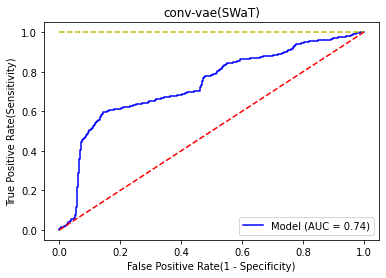

In [22]:
plt.title('conv-vae(' + model_name + ')')
plt.xlabel('False Positive Rate(1 - Specificity)')
plt.ylabel('True Positive Rate(Sensitivity)')

plt.plot(false_positive_rate, true_positive_rate, 'b', label='Model (AUC = %0.2f)'% roc_auc)
plt.plot([0,1],[1,1],'y--')
plt.plot([0,1],[0,1],'r--')

plt.legend(loc='lower right')
plt.savefig('./graph/conv_vae_' + model_name + '.png', dpi=300)
plt.show()